# Network Analysis in Python

-  Networkx is a Python module that provides tools for analyzing networks in various different ways. It also contains algorithms such as Dijkstra’s algorithm or A* algoritm that are commonly used to find shortest paths along transportation network.

-  The OSMnx package enables us to retrieve routable networks from OpenStreetMap for various transport modes (walking, cycling and driving). 
    1. OSMnx also combines some functionalities from networkx module to make it straightforward to conduct routing analysis based on OpenStreetMap data.

test the routing functionalities of OSMnx by finding a shortest path between two points based on drivable roads. With tiny modifications, it is also possible to repeat the analysis for the walkable street network.

# Get the network

In [1]:
import osmnx as ox
import networkx as nx
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from pyproj import CRS
import contextily as ctx

-  fetching netowrk data from OpenStreetMap using OSMnx, it is possible to define the type of street network using the **network_type** parameter 

In [3]:
place_name = "Kamppi, Helsinki, Finland"

#retrieve the bike network for kampi, helsinki, finland
graph = ox.graph_from_place(place_name, network_type='bike')

C:\Anaconda\envs\python-gis\lib\site-packages\osmnx\geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))


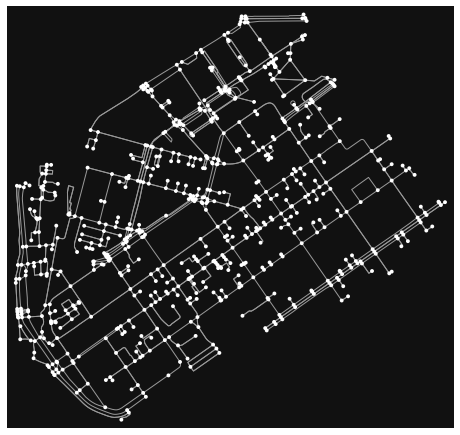

In [4]:
#plot the graph
fig, ax = ox.plot_graph(graph)

**Sometimes the shortest path might go slightly outside the defined area of interest.** 
- We can fetch the network for a larger area than district of Kamppi,in case the shortest path is not completely inside its boundaries.

In [5]:
#get the boundary of interest - polygon
place_polygon = ox.geocode_to_gdf(place_name)

#reproject the polygon to a local projected CRS
place_polygon = place_polygon.to_crs(epsg=3067)

#buffer the polygon add 200 feet on all sides
place_polygon["geometry"]= place_polygon.buffer(200)

#reproject polygon back to wgs84 as required by osmnx
place_polygon = place_polygon.to_crs(epsg=4326)

#retrieve the network
graph = ox.graph_from_polygon(place_polygon["geometry"].values[0], network_type='bike')

C:\Anaconda\envs\python-gis\lib\site-packages\osmnx\geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))


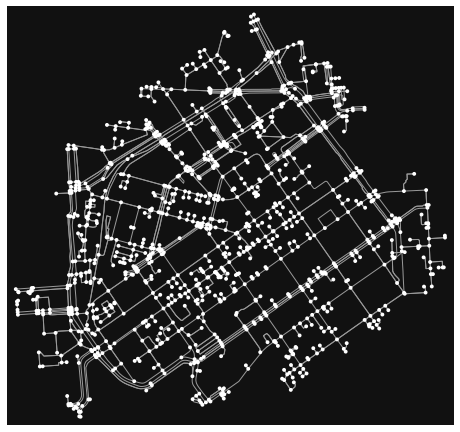

In [6]:
fig, ax = ox.plot_graph(graph)

Converting graph into a GeoDataFrame can be done with function graph_to_gdfs() that we already used in previous tutorial. With parameters nodes and edges, it is possible to control whether to retrieve both nodes and edges from the graph.

In [8]:
#retrieve only edges from the graph
edges = ox.graph_to_gdfs(graph, nodes=False, edges=True)

In [9]:
#check the columns
edges.columns

Index(['osmid', 'oneway', 'lanes', 'name', 'highway', 'maxspeed', 'length',
       'geometry', 'junction', 'access', 'bridge', 'tunnel', 'service'],
      dtype='object')

In [10]:
#check crs
edges.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

**Note that the CRS of the GeoDataFrame is be WGS84 (epsg: 4326).**

In [11]:
edges.head()

osmid  oneway lanes             name  \
u        v          key                                                       
25216594 1372425721 0               23717777    True     2    Porkkalankatu   
         1372425714 0               23856784    True     2   Mechelininkatu   
25238865 146447626  0    [59355210, 4229487]   False     2        Santakatu   
         57661989   0                7842621   False   NaN  Sinikaislankuja   
         314767800  0              231643806   False   NaN              NaN   

                             highway maxspeed  length  \
u        v          key                                 
25216594 1372425721 0        primary       40  10.404   
         1372425714 0        primary       40  40.885   
25238865 146447626  0    residential       30  44.303   
         57661989   0    residential       30  76.704   
         314767800  0       cycleway      NaN  60.066   

                                                                  geometry  \
u        v          key                                                      
25216594 1372425721 0    LINESTRING (24.92106 60.16479, 24.92087 60.16479)   
         1372425714 0    LINESTRING (24.92106 60.16479, 24.92095 60.164...   
25238865 146447626  0    LINESTRING (24.91994 60.16279, 24.91932 60.162...   
         57661989   0    LINESTRING (24.91994 60.16279, 24.91995 60.162...   
         314767800  0    LINESTRING (24.91994 60.16279, 24.92014 60.162...   

                        junction access bridge tunnel service  
u        v          key                                        
25216594 1372425721 0        NaN    NaN    NaN    NaN     NaN  
         1372425714 0        NaN    NaN    NaN    NaN     NaN  
25238865 146447626  0        NaN    NaN    NaN    NaN     NaN  
         57661989   0        NaN    NaN    NaN    NaN     NaN  
         314767800  0        NaN    NaN    NaN    NaN     NaN

- Most of the attributes come directly from the OpenStreetMap, however, columns u and v are Networkx specific ids.

In [12]:
#look at features found in the highway column
edges['highway'].value_counts()

service                      878
cycleway                     489
residential                  466
tertiary                     217
primary                      165
pedestrian                   158
secondary                    121
unclassified                  42
living_street                 16
[service, living_street]       6
[cycleway, pedestrian]         4
[residential, pedestrian]      4
[residential, cycleway]        3
[cycleway, residential]        3
tertiary_link                  2
[service, pedestrian]          2
primary_link                   1
[service, unclassified]        1
Name: highway, dtype: int64

- we can confirm that as a result our street network indeed only contains such streets where it is allowed to drive with a car as there are no e.g.footways included in the data. 

As the data is in WGS84 format, we might want to reproject our data into a metric system before proceeding to the shortest path analysis. 

- We can re-project the graph from latitudes and longitudes to an appropriate UTM zone using the **project_graph()** function from OSMnx.

In [13]:
#project the data
graph_proj = ox.project_graph(graph)

In [14]:
#get edges and nodes
nodes_proj, edges_proj = ox.graph_to_gdfs(graph_proj, nodes=True, edges=True)

In [15]:
print("Coordinate system: ", edges_proj.crs)

Coordinate system:  +proj=utm +zone=35 +ellps=WGS84 +datum=WGS84 +units=m +no_defs +type=crs


In [16]:
edges_proj.head()

osmid  oneway  \
u          v          key                                                    
25216594   1372425721 0                                   23717777    True   
           1372425714 0                                   23856784    True   
1372425721 25290781   0                                   29191566   False   
           60070671   0          [930820929, 930820930, 654270815]   False   
1372425714 25238874   0    [78537378, 8169098, 29081876, 78537375]    True   

                            lanes            name   highway maxspeed   length  \
u          v          key                                                       
25216594   1372425721 0         2   Porkkalankatu   primary       40   10.404   
           1372425714 0         2  Mechelininkatu   primary       40   40.885   
1372425721 25290781   0       NaN             NaN  cycleway      NaN  228.587   
           60070671   0       NaN             NaN  cycleway      NaN   41.006   
1372425714 25238874   0    [3, 2]  Mechelininkatu   primary       40   85.540   

                                                                    geometry  \
u          v          key                                                      
25216594   1372425721 0    LINESTRING (384631.322 6671580.071, 384620.884...   
           1372425714 0    LINESTRING (384631.322 6671580.071, 384624.750...   
1372425721 25290781   0    LINESTRING (384620.884 6671579.965, 384621.184...   
           60070671   0    LINESTRING (384620.884 6671579.965, 384620.720...   
1372425714 25238874   0    LINESTRING (384624.179 6671539.986, 384623.768...   

                          junction bridge tunnel access service  
u          v          key                                        
25216594   1372425721 0        NaN    NaN    NaN    NaN     NaN  
           1372425714 0        NaN    NaN    NaN    NaN     NaN  
1372425721 25290781   0        NaN    NaN    NaN    NaN     NaN  
           60070671   0        NaN    NaN    NaN    NaN     NaN  
1372425714 25238874   0        NaN    NaN    NaN    NaN     NaN

- from the CRS the data is now in UTM projection using zone 35 which is the one used for Finland, and indeed the orientation of the map and the geometry values also confirm this.

In [17]:
#check the crs projection
CRS(edges_proj.crs).to_epsg()

32635

- The projection is now WGS 84 / UTM zone 35N, EPSG:32635.

# Analyzing the network properties

Now as we have seen some of the basic functionalities of OSMnx such as downloading the data and converting data from graph to GeoDataFrame, we can take a look some of the analytical features of omsnx. 

- To calculate some of the basic street network measures we can use basic_stats() function in OSMnx:

In [18]:
#calculate network statistics
stats = ox.basic_stats(graph_proj, circuity_dist ='euclidean')
stats

C:\Anaconda\envs\python-gis\lib\site-packages\osmnx\stats.py:370: UserWarning: The `circuity_dist` argument has been deprecated and will be removed in a future release.
  warnings.warn(msg)


{'n': 1197,
 'm': 2578,
 'k_avg': 4.307435254803676,
 'edge_length_total': 91387.91999999997,
 'edge_length_avg': 35.44915438324281,
 'streets_per_node_avg': 2.7017543859649122,
 'streets_per_node_counts': {0: 0, 1: 321, 2: 16, 3: 577, 4: 265, 5: 18},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.2681704260651629,
  2: 0.013366750208855471,
  3: 0.48203842940685043,
  4: 0.22138680033416874,
  5: 0.015037593984962405},
 'intersection_count': 876,
 'street_length_total': 57052.897999999885,
 'street_segment_count': 1576,
 'street_length_avg': 36.20107741116744,
 'circuity_avg': 1.0416637411172323,
 'self_loop_proportion': 0.0019035532994923859}

To be able to extract the more advanced statistics (and some of the missing ones above) from the street network, it is required to have information about the coverage area of the network. 

- Let’s calculate the area of the convex hull of the street network and see what we can get.

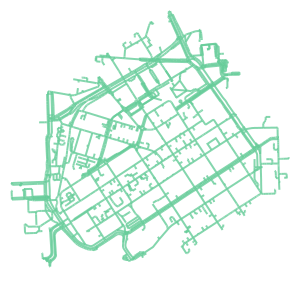

In [22]:
#combine all linestring geometries of edges into 1 multi linestring
edges_proj.unary_union

Returns a GeoSeries of geometries representing the convex hull of each geometry.

The convex hull of a geometry is the smallest convex Polygon containing all the points in each geometry, unless the number of points in the geometric object is less than three. For two points, the convex hull collapses to a LineString; for 1, a Point.

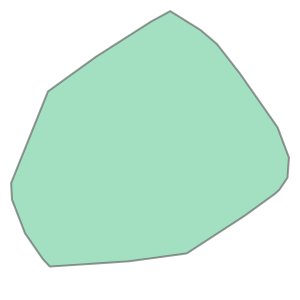

In [23]:
#get the minimum boundary covering all edges 
convex_hull = edges_proj.unary_union.convex_hull

#show output 
convex_hull

use the Convex Hull above to calculate extended statistics for the network. As some of the metrics are produced separately for each node, they produce a lot of output. Here, we combine the basic and extended statistics into one pandas Series to keep things in more compact form.

In [25]:
#calculate area of the convex hull polygon
area = convex_hull.area

#calculate statistics with density information
stats = ox.basic_stats(graph_proj, area=area)
extended_stats = ox.extended_stats(graph_proj, ecc=True, cc=True)

#add extended stats to the basic stats
for key, value in extended_stats.items():
    stats[key] = value

#convert the dictionary to a pandas series for a nicer output
pd.Series(stats)

C:\Anaconda\envs\python-gis\lib\site-packages\osmnx\stats.py:458: UserWarning: The extended_stats function has been deprecated and will be removed in a future release. Use NetworkX directly for extended topological measures.
  warnings.warn(msg)


n                                                                                   1197
m                                                                                   2578
k_avg                                                                           4.307435
edge_length_total                                                               91387.92
edge_length_avg                                                                35.449154
streets_per_node_avg                                                            2.701754
streets_per_node_counts                     {0: 0, 1: 321, 2: 16, 3: 577, 4: 265, 5: 18}
streets_per_node_proportions           {0: 0.0, 1: 0.2681704260651629, 2: 0.013366750...
intersection_count                                                                   876
street_length_total                                                            57052.898
street_segment_count                                                                1576
street_length_avg    

As we can see, now we have a LOT of information about our street network that can be used to understand its structure. 
- We can for example see that the **average node density** in our network is 149 nodes/km and that the **total edge length** of our network is almost 20 kilometers.

Furthermore, we can see that the **degree centrality** of our network is on average 0.0326515. 
- Degree is a simple centrality measure that counts how many neighbors a node has (here a fraction of nodes it is connected to). 

Another interesting measure is the **PageRank** that measures the importance of specific node in the graph.
- Here we can see that the most important node in our graph seem to a node with osmid 25416262. PageRank was the algorithm that Google first developed (Larry Page & Sergei Brin) to order the search engine results and became famous for.


# Shortest path analysis
- calculate the shortest path between 2 points using the shortest path function in Networkx

# Specify origin and destinion points.

1. Maria 01 - and old hospital area and current startup hub.

2. ruttopuisto - a park. Official name of this park is “Vanha kirkkopuisto”, but nominatim is also able to geocode the nickname.


We figure out the coordinates for these locations manually, and create shapely points based on the coordinates. 
However, it is more handy to fetch the location of our source destination directly from OSM:

In [26]:
#set place name
placename = "Maria 01, Helsinki"

In [27]:
#get the boundary of the placename
geocoded_place = ox.geocode_to_gdf(placename)

C:\Anaconda\envs\python-gis\lib\site-packages\osmnx\geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))


In [28]:
#check the geocoded result
geocoded_place

,geometry,bbox_north,bbox_south,bbox_east,bbox_west,place_id,osm_type,osm_id,lat,lon,display_name,class,type,importance
0,"POLYGON ((24.92122 60.16644, 24.92126 60.16625...",60.167525,60.16624,24.92317,24.921221,106651985,way,23856740,60.166884,24.921661,"Maria 01, Baana, Hietalahti, Kamppi, Helsinki,...",building,yes,0.58084


<AxesSubplot:>

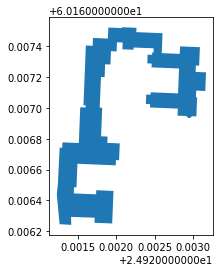

In [29]:
geocoded_place.plot()

As output, we received the building footprint. 
 - From here, we can get the **centroid as the source location of our shortest path analysis**. 
 
However, we first need to project the data into the correct crs:

In [30]:
#re project hospital building polygon to the same CRS as the road network
geocoded_place = geocoded_place.to_crs( CRS(edges_proj.crs) )

In [34]:
#get centroid as shapely point
origin = geocoded_place['geometry'].centroid.values[0]

In [37]:
print(origin)

POINT (384692.1787195493 6671817.486579246)


Great! Now we have defined the origin point for our network analysis. 
- We can repeat the same steps to retrieve central point of ruttopuisto-park as the destination:

In [39]:
#set the placename
placename = "ruttopuisto"

#geocode the place name
geocoded_place = ox.geocode_to_gdf(placename)

#reproject into the same CRS as the road network
geocoded_place = geocoded_place.to_crs( CRS(edges_proj.crs) )

destination = geocoded_place['geometry'].centroid.values[0]

C:\Anaconda\envs\python-gis\lib\site-packages\osmnx\geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))


In [40]:
print(destination)

POINT (385673.4277923344 6671690.223032337)


**Now we have shapely points representing the origin and destination locations for our network analysis.**

- Next step is to find these points on the routable network before the final routing.

# Nearest node

Let’s now find the nearest graph nodes (and their node IDs) to these points using OSMnx get_nearest_node. 
- As a starting point, we have the two Shapely Point objects we just defined as the origin and destination locations.

According to the documentation of this function, we need to parse Point coordinates as coordinate-tuples in this order: latitude, longitude(or y, x). 

As our data is now projected to UTM projection, we need to specify with method parameter that the function uses 'euclidean' distances to calculate the distance from the point to the closest node (with decimal derees, use 'haversine', which determines the great-circle distances). 

The method parameter is important if you want to know the actual distance between the Point and the closest node which you can retrieve by specifying parameter return_dist=True.

In [41]:
#get origin x and y coordinates
orig_xy = (origin.y , origin.x)

#get target x and y coordinates
target_xy = (destination.y, destination.x )

In [43]:
#find the node in te graph that is closest to the origin point( here, we want to get the node id)
orig_node_id = ox.get_nearest_node(graph_proj, orig_xy, method='euclidean')
orig_node_id

C:\Anaconda\envs\python-gis\lib\site-packages\osmnx\distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)


319719983

In [44]:
#find the node in the graph that is closest to the target point(get the node id)
target_node_id = ox.get_nearest_node(graph_proj, target_xy, method='euclidean')
target_node_id

C:\Anaconda\envs\python-gis\lib\site-packages\osmnx\distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)


1377208998

Now we have the IDs for the closest nodes that were found from the graph to the origin and target points that we specified.